<a href="https://colab.research.google.com/github/chanukaDissanayaka/RideFareClassification/blob/master/Ridefare_submission_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports

import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from pandas import DataFrame

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

import numpy as np

RANDOM_SEED = 4

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#dataframe = pd.read_csv("/content/train.csv")
#test = pd.read_csv("/content/test.csv")

dataframe = pd.read_csv("/content/gdrive/My Drive/ML_RideFare/Data/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/ML_RideFare/Data/test.csv")

dataframe.isna().sum(axis = 0)
#dataframe = dataframe.fillna(method='ffill')
#dataframe = dataframe.dropna()

tripid                         0
additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
dtype: int64

In [ ]:
def preprocess_train_data(dataframe):
  feature_set = dataframe.iloc[:,1:13]

  features = feature_set

  features['pickup_time'] = pd.to_datetime(features['pickup_time'], format="%m/%d/%Y %H:%M")
  features['drop_time'] = pd.to_datetime(features['drop_time'], format="%m/%d/%Y %H:%M")

  td = features

  td['pickup_time_year'] = td['pickup_time'].dt.year
  td['pickup_time_month'] = td['pickup_time'].dt.month
  td['pickup_time_day'] = td['pickup_time'].dt.day
  td['pickup_time_hour'] = td['pickup_time'].dt.hour
  td['pickup_time_minute'] = td['pickup_time'].dt.minute

  td['drop_time_year'] = td['drop_time'].dt.year
  td['drop_time_month'] = td['drop_time'].dt.month
  td['drop_time_day'] = td['drop_time'].dt.day
  td['drop_time_hour'] = td['drop_time'].dt.hour
  td['drop_time_minute'] = td['drop_time'].dt.minute

  td['day_of_week'] = td['pickup_time'].dt.day_name()
  td['day_of_week'] = OrdinalEncoder().fit_transform(td[['day_of_week']])

  td['duration_calculated'] = td['drop_time'] - td['pickup_time']
  td['duration_calculated'] = td['duration_calculated'].dt.total_seconds().astype(int)

  td = td.drop('pickup_time',1)
  td = td.drop('drop_time',1)

  td = get_trip_distance(td)
  td = get_X_distance(td)
  td = get_Y_distance(td)
  td = get_pick_XY(td)
  td = get_drop_XY(td)
  td = transform_hour(td)
  td = set_time_of_the_day(td)
  td = set_fare_duration(td)
  td = set_driving_duration(td)
  td = get_exact_fare(td)
  td = combine_time_fare(td)
  td = calculate_direction(td)
  td = duration_category(td)

  return td

def get_labels(dataframe):
  label_set = dataframe.iloc[:, 13:14]
  #rev_label_set = label_set
  rev_label_set = label_set.replace({'correct':'incorrect', 'incorrect':'correct'})

  encoder = LabelEncoder()
  encoder.fit(rev_label_set)
  labels = encoder.transform(rev_label_set)
  return labels

def set_time_of_the_day(cleaned_train_set):
  cleaned_train_set.head()
  newFrame = cleaned_train_set
  tt = newFrame

  d0_index = newFrame[(newFrame['pickup_time_hour']>=0) & (newFrame['pickup_time_hour'] < 6 )].index
  tt.loc[d0_index,'time_of_day']=0

  d1_index = newFrame[(newFrame['pickup_time_hour']>=6) & (newFrame['pickup_time_hour'] < 12 )].index
  tt.loc[d1_index,'time_of_day']=1

  d2_index = newFrame[(newFrame['pickup_time_hour']>=12) & (newFrame['pickup_time_hour'] < 18 )].index
  tt.loc[d2_index,'time_of_day']=2

  d3_index = newFrame[(newFrame['pickup_time_hour']>=18) & (newFrame['pickup_time_hour'] < 24 )].index
  tt.loc[d3_index,'time_of_day']=3

  return tt

def haversine_distance(lat1, lon1, lat2, lon2):
  r = 6371
  phi1 = np.radians(lat1)
  phi2 = np.radians(lat2)
  d_phi = np.radians(lat2-lat1)
  d_lambda = np.radians(lon2-lon1)

  a = np.sin(d_phi /2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda/2)**2
  res = r*(2* np.arctan2(np.sqrt(a), np.sqrt(1-a)))

  return np.round(res,2)
  return res

def get_trip_distance(frame):
  newFrame = frame
  newFrame["distance"] = haversine_distance(frame['pick_lat'],frame['drop_lat'],frame['pick_lon'],frame['drop_lon'])
  return newFrame

def get_trip_distance_eucld(frame):
  newFrame = frame
  newFrame["distance"] = (((frame['pick_lat']-frame['drop_lat'])**2)+((frame['pick_lon']-frame['drop_lon'])**2)**0.5)
  return newFrame

def get_X_distance(frame):
  newFrame = frame
  newFrame["distance_X"] = ((frame['pick_lat']-frame['drop_lat']))
  return newFrame

def get_Y_distance(frame):
  newFrame = frame
  newFrame["distance_Y"] = ((frame['pick_lon']-frame['drop_lon']))
  return newFrame

def get_pick_XY(frame):
  newFrame = frame
  newFrame["pick_X"] = np.cos(frame['pick_lat'])* np.cos(frame['pick_lon'])
  newFrame["pick_Y"] = np.cos(frame['pick_lat'])* np.sin(frame['pick_lon'])
  return newFrame

def get_drop_XY(frame):
  newFrame = frame
  newFrame["drop_X"] = np.cos(frame['drop_lat'])* np.cos(frame['drop_lon'])
  newFrame["drop_Y"] = np.cos(frame['drop_lat'])* np.sin(frame['drop_lon'])
  return newFrame

def transform_hour(frame):
  newFrame = frame
  newFrame["pick_hour_sin"] = np.sin(np.radians(3*frame['pickup_time_hour']))
  newFrame["drop_hour_sin"] = np.sin(np.radians(3*frame['drop_time_hour']))

  newFrame["pick_hour_cos"] = np.cos(np.radians(3*frame['pickup_time_hour']))
  newFrame["drop_hour_cos"] = np.cos(np.radians(3*frame['drop_time_hour']))
  return newFrame

def set_fare_duration(imputed_train_set):
  df = imputed_train_set

  """df['total_fare'] = ((df['fare']-df['fare'].mean())/df['fare'].std() +
                      (df['additional_fare']-df['additional_fare'].mean())/df['additional_fare'].std()+ 
                      (df['meter_waiting_fare']-df['meter_waiting_fare'].mean())/df['meter_waiting_fare'].std())"""

  df['total_fare'] =  df['fare'] + df['additional_fare'] + df['meter_waiting_fare']
  df['total_additional_fare'] = df['additional_fare'] + df['meter_waiting_fare']
  df['total_waiting_time'] = df['meter_waiting'] + df['meter_waiting_till_pickup']
  df['total_time'] = df['total_waiting_time'] + df['duration']

  df['waiting_factor'] = ((df['meter_waiting']-df['meter_waiting'].mean())/df['meter_waiting'].std() +
                      (df['meter_waiting_fare']-df['meter_waiting_fare'].mean())/df['meter_waiting_fare'].std()+ 
                      (df['meter_waiting_till_pickup']-df['meter_waiting_till_pickup'].mean())/df['meter_waiting_till_pickup'].std())

  return df

def set_driving_duration(train_set):
  df = train_set

  df['driving_duration'] = df['duration'] - df['meter_waiting']
  return df

def get_exact_fare(train_set):
  df = train_set
  df['exact_fare'] = df['fare'] - df['additional_fare']- df['meter_waiting_fare']
  return df

def combine_time_fare(train_set):
  df = train_set

  df['additional'] = ((df['additional_fare']-df['additional_fare'].mean())/df['additional_fare'].std() +
                        (df['meter_waiting_till_pickup']-df['meter_waiting_till_pickup'].mean())/df['meter_waiting_till_pickup'].std())

  df['waiting'] = ((df['meter_waiting']-df['meter_waiting'].mean())/df['meter_waiting'].std() +
                        (df['meter_waiting_fare']-df['meter_waiting_fare'].mean())/df['meter_waiting_fare'].std())

  df['exact'] = ((df['exact_fare']-df['exact_fare'].mean())/df['exact_fare'].std() +
                        (df['driving_duration']-df['driving_duration'].mean())/df['driving_duration'].std())

  return df

def calculate_direction(frame):
    newFrame = frame

    distance_X = frame['distance_X']
    distance_Y = frame['distance_Y']

    result = np.zeros(len(distance_X))
    l = np.sqrt(distance_X**2 + distance_Y**2)
    result[distance_X>0] = (180/np.pi)*np.arcsin(distance_Y[distance_X>0]/l[distance_X>0])
    idx = (distance_X<0) & (distance_Y>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(distance_Y[idx]/l[idx])
    idx = (distance_X<0) & (distance_Y<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(distance_Y[idx]/l[idx])
    newFrame['direction'] = result
    return newFrame

def duration_category(dataframe):
  newFrame = dataframe

  d0_index = newFrame[(newFrame['duration'] < 3600 )].index
  newFrame.loc[d0_index,'duration_category']=0

  d1_index = newFrame[(newFrame['duration']>=3600) & (newFrame['duration'] < 20000 )].index
  newFrame.loc[d1_index,'duration_category']=1

  d2_index = newFrame[(newFrame['duration']>=20000)].index
  newFrame.loc[d2_index,'duration_category']=2
  return newFrame



In [ ]:
cleaned_train_set = preprocess_train_data(dataframe)
labels = get_labels(dataframe)
cleaned_train_set.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,time_of_day,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction,duration_category
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019,11,1,0,20,2019,11,1,0,34,0.0,840,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0.000000,0.000000,1.000000,1.000000,0.0,280.8200,10.5000,120.0,954.0,-0.249582,778.0,259.8200,-0.142170,-0.139942,-0.172708,152.753420,0.0
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019,11,1,0,56,2019,11,1,1,9,0.0,780,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0.000000,0.052336,1.000000,0.998630,0.0,208.3500,10.5000,181.0,972.0,-0.092347,744.0,187.3500,0.016182,-0.141058,-0.436406,167.641274,0.0
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019,11,1,1,8,2019,11,1,1,26,0.0,1080,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0.052336,0.052336,0.998630,0.998630,0.0,312.1400,10.5000,141.0,1228.0,-0.253392,1007.0,291.1400,-0.148956,-0.136965,0.048955,-119.757345,0.0
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019,11,1,2,27,2019,11,1,2,37,0.0,600,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0.104528,0.104528,0.994522,0.994522,0.0,108.4638,26.1638,339.0,937.0,-0.180218,327.0,56.1362,-0.133121,-0.079627,-1.092480,-103.181677,0.0
4,NaN,NaN,NaN,NaN,NaN,6.87441,79.8615,6.84478,79.9290,358.39,2019,11,1,3,34,2019,11,1,3,51,0.0,1020,8927.76,0.02963,-0.0675,-0.204695,-0.804630,-0.152875,-0.832487,0.156434,0.156434,0.987688,0.987688,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-66.300305,NaN


In [ ]:
#drop outliers

data_exp = cleaned_train_set
data_exp['labels'] = labels

#data_exp = data_exp[data_exp.duration<=10000]
data_exp = data_exp[data_exp.drop_lon>70.0]
data_exp = data_exp[data_exp.drop_lat<10.0]
#data_exp = data_exp[data_exp.meter_waiting<=20000]
#data_exp = data_exp[data_exp.meter_waiting_till_pickup<=1000]
data_exp.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,time_of_day,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction,duration_category,labels
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019,11,1,0,20,2019,11,1,0,34,0.0,840,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0.000000,0.000000,1.000000,1.000000,0.0,280.8200,10.5000,120.0,954.0,-0.249582,778.0,259.8200,-0.142170,-0.139942,-0.172708,152.753420,0.0,1
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019,11,1,0,56,2019,11,1,1,9,0.0,780,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0.000000,0.052336,1.000000,0.998630,0.0,208.3500,10.5000,181.0,972.0,-0.092347,744.0,187.3500,0.016182,-0.141058,-0.436406,167.641274,0.0,1
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019,11,1,1,8,2019,11,1,1,26,0.0,1080,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0.052336,0.052336,0.998630,0.998630,0.0,312.1400,10.5000,141.0,1228.0,-0.253392,1007.0,291.1400,-0.148956,-0.136965,0.048955,-119.757345,0.0,1
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019,11,1,2,27,2019,11,1,2,37,0.0,600,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0.104528,0.104528,0.994522,0.994522,0.0,108.4638,26.1638,339.0,937.0,-0.180218,327.0,56.1362,-0.133121,-0.079627,-1.092480,-103.181677,0.0,1
4,NaN,NaN,NaN,NaN,NaN,6.87441,79.8615,6.84478,79.9290,358.39,2019,11,1,3,34,2019,11,1,3,51,0.0,1020,8927.76,0.02963,-0.0675,-0.204695,-0.804630,-0.152875,-0.832487,0.156434,0.156434,0.987688,0.987688,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-66.300305,NaN,1


In [ ]:
from sklearn.impute import SimpleImputer

data_exp.duration.fillna(data_exp.duration_calculated, inplace=True)
data_exp.head()
data_exp.dropna()

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
dframe = imp_mean.fit_transform(data_exp)
k = cleaned_train_set.keys()
imputed_train_set = data_exp
imputed_train_set[k] = dframe
imputed_train_set.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,time_of_day,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction,duration_category,labels
count,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.00000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000,17175.000000
mean,13.681971,1713.716448,623.155866,31.683695,112.003493,6.965470,79.998352,6.966191,79.999553,311.860618,2019.339156,7.954993,15.904163,13.817817,29.470393,2019.339272,7.953828,15.905328,14.096477,29.411936,2.957205,1714.012227,8920.841656,-0.000721,-0.001201,-0.106987,-0.735061,-0.105948,-0.734598,0.641733,0.651905,0.725446,0.715248,1.888151,356.930469,45.364747,735.71214,2430.819796,-0.002072,1070.740378,265.943241,-0.001243,-0.001482,-0.004445,3.656533,0.064512,0.902125
std,98.394768,8101.925491,8016.121142,462.764368,439.480938,0.210731,0.243344,0.211497,0.243475,602.963712,0.473437,4.999151,8.852703,4.824092,17.288600,0.473476,4.999606,8.852866,4.887003,17.379719,2.046102,8101.687789,23.055015,0.045685,0.036257,0.145466,0.136190,0.145672,0.136876,0.191001,0.192707,0.159465,0.162200,0.819728,1060.834229,491.946779,8041.50152,15988.711676,2.249467,1978.389779,292.210769,1.407614,1.988047,1.684504,104.819043,0.259502,0.297154
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,79.796700,0.000000,2019.000000,1.000000,1.000000,0.000000,0.000000,2019.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8825.190000,-0.672030,-0.648200,-0.211792,-0.974654,-0.217328,-0.999002,0.000000,0.000000,0.358368,0.358368,0.000000,0.000000,0.000000,0.00000,28.000000,-0.401305,-210124.000000,-37.643641,-0.379463,-0.146887,-106.874266,-179.878585,0.000000,0.000000
25%,10.500000,547.000000,33.000000,0.000000,26.000000,6.865075,79.870400,6.865620,79.870100,125.985000,2019.000000,1.000000,8.000000,10.000000,15.000000,2019.000000,1.000000,8.000000,11.000000,14.000000,1.000000,540.000000,8910.440000,-0.018100,-0.014100,-0.192090,-0.815998,-0.192064,-0.816126,0.500000,0.544639,0.587785,0.587785,1.000000,142.136100,10.500000,117.00000,715.000000,-0.300188,449.000000,107.827200,-0.221345,-0.141678,-0.831741,-82.201414,0.000000,1.000000
50%,10.500000,1012.000000,123.000000,0.116600,73.000000,6.914100,79.898600,6.916160,79.899100,211.190000,2019.000000,11.000000,16.000000,14.000000,29.000000,2019.000000,11.000000,16.000000,14.000000,29.000000,3.000000,1020.000000,8922.140000,-0.000030,0.000000,-0.159474,-0.785910,-0.159402,-0.784683,0.669131,0.669131,0.743145,0.743145,2.000000,233.710000,10.538500,243.00000,1280.000000,-0.176971,811.000000,187.563285,-0.105975,-0.126672,-0.379805,0.000000,0.000000,1.000000
75%,10.500000,1808.000000,348.000000,13.987600,143.000000,7.043035,79.956600,7.047070,79.960250,364.330000,2020.000000,12.000000,24.000000,18.000000,45.000000,2020.000000,12.000000,24.000000,18.000000,44.000000,5.000000,1800.000000,8928.780000,0.016350,0.013600,-0.123105,-0.709950,-0.119536,-0.707306,0.809017,0.809017,0.866025,0.838671,3.000000,395.276100,29.805200,492.00000,2270.000000,0.006868,1392.500000,3

In [ ]:
imputed_train_set.head(100)

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,time_of_day,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction,duration_category,labels
0,10.5,834.0,56.0,0.00000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019.0,11.0,1.0,0.0,20.0,2019.0,11.0,1.0,0.0,34.0,0.0,840.0,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0.000000,0.000000,1.000000,1.000000,0.0,280.82000,10.50000,120.0,954.0,-0.249582,778.0,259.820000,-0.142170,-0.139942,-0.172708,152.753420,0.0,1.0
1,10.5,791.0,47.0,0.00000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019.0,11.0,1.0,0.0,56.0,2019.0,11.0,1.0,1.0,9.0,0.0,780.0,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0.000000,0.052336,1.000000,0.998630,0.0,208.35000,10.50000,181.0,972.0,-0.092347,744.0,187.350000,0.016182,-0.141058,-0.436406,167.641274,0.0,1.0
2,10.5,1087.0,80.0,0.00000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019.0,11.0,1.0,1.0,8.0,2019.0,11.0,1.0,1.0,26.0,0.0,1080.0,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0.052336,0.052336,0.998630,0.998630,0.0,312.14000,10.50000,141.0,1228.0,-0.253392,1007.0,291.140000,-0.148956,-0.136965,0.048955,-119.757345,0.0,1.0
3,10.5,598.0,271.0,15.66380,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019.0,11.0,1.0,2.0,27.0,2019.0,11.0,1.0,2.0,37.0,0.0,600.0,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0.104528,0.104528,0.994522,0.994522,0.0,108.46380,26.16380,339.0,937.0,-0.180218,327.0,56.136200,-0.133121,-0.079627,-1.092480,-103.181677,0.0,1.0
4,10.5,1020.0,123.0,0.11660,73.0,6.87441,79.8615,6.84478,79.9290,358.39,2019.0,11.0,1.0,3.0,34.0,2019.0,11.0,1.0,3.0,51.0,0.0,1020.0,8927.76,0.02963,-0.0675,-0.204695,-0.804630,-0.152875,-0.832487,0.156434,0.156434,0.987688,0.987688,0.0,233.71000,10.53850,243.0,1280.0,-0.176971,811.0,187.563285,-0.105975,-0.126672,-0.379805,-66.300305,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10.5,1388.0,207.0,11.99729,6.0,6.80980,79.8962,6.81551,79.9344,233.62,2019.0,11.0,1.0,15.0,15.0,2019.0,11.0,1.0,15.0,39.0,0.0,1440.0,8936.52,-0.00571,-0.0382,-0.183946,-0.844717,-0.151046,-0.848287,0.707107,0.707107,0.707107,0.707107,2.0,256.11729,22.49729,213.0,1601.0,-0.336286,1181.0,211.122710,-0.273375,-0.095441,-0.135897,-98.501426,0.0,1.0
96,10.5,2954.0,2330.0,135.83900,134.0,6.86568,79.9084,6.86565,79.9086,268.13,2019.0,11.0,1.0,15.0,20.0,2019.0,11.0,1.0,16.0,9.0,0.0,2940.0,8929.33,0.00003,-0.0002,-0.167718,-0.818078,-0.167558,-0.818127,0.707107,0.743145,0.707107,0.669131,2.0,414.46900,146.33900,2464.0,5418.0,0.482613,624.0,121.791000,0.016182,0.433901,-0.719805,-81.469234,0.0,1.0
97,10.5,1644.0,739.0,34.62220,30.0,6.85916,79.8964,6.89307,79.8712,243.64,2019.0,11.0,1.0,15.0,25.0,2019.0,11.0,1.0,15.0,53.0,0.0,1680.0,8928.47,-0.03391,0.0252,-0.178281,-0.819493,-0.194381,-0.796334,0.707107,0.707107,0.707107,0.707107,2.0,288.76220,45.12220,769.0,2413.0,-0.167411,905.0,198.517800,-0.219083,0.019142,-0.317493,143.382350,0.0,1.0
98,10.5,1410.0,20.0,0.00000,68.0,6.85847,79.9159,6.78908,79.9229,357.14,2019.0,11.0,1.0,15.0,30.0,2019.0,11.0,1.0,15.0,53.0,0.0,1380.0,8932.05,0.06939,-0.0070,-0.162341,-0.823182,-0.163237,-0.859375,0.707107,0.707107,0.707107,0.707107,2.0,367.64000,10.50000,88.0,1498.0,-0.244998,1390.0,346.640000,-0.133121,-0.144407,0.430293,-5.760458,0.0,1.0


In [ ]:
tx = data_exp[data_exp.duration>=10000]
tx.head(20)

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,time_of_day,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction,labels
74,5.0,162747.0,162277.0,9460.749100,0.0,6.78440,79.8845,6.89959,79.8646,10264.42,2019.0,11.0,1.0,13.0,35.0,2019.0,11.0,3.0,10.0,48.0,0.0,162780.0,8936.06,-0.11519,0.0199,-0.196615,-0.854676,-0.198718,-0.791395,0.629320,0.500000,0.777146,0.866025,2.0,19730.169100,9465.749100,162277.0,325024.0,40.048736,470.0,798.670900,-0.342518,40.303155,1.506190,170.198439,1
86,10.5,10823.0,0.0,0.000000,324.0,6.91292,79.8776,6.91489,79.8774,115.10,2019.0,11.0,1.0,14.0,38.0,2019.0,11.0,1.0,17.0,38.0,0.0,10800.0,8921.72,-0.00197,0.0002,-0.186618,-0.786343,-0.186506,-0.785175,0.669131,0.777146,0.743145,0.629320,2.0,125.600000,10.500000,324.0,11147.0,0.331636,10823.0,104.600000,0.445993,-0.146887,4.347142,174.203031,0
280,10.5,63273.0,61762.0,3481.294000,133.0,6.84863,79.9316,6.83766,79.9676,4328.32,2019.0,11.0,2.0,15.0,54.0,2019.0,11.0,3.0,9.0,28.0,2.0,63240.0,8933.52,0.01097,-0.0360,-0.150343,-0.830858,-0.121172,-0.841498,0.707107,0.453990,0.707107,0.891007,2.0,7820.114000,3491.794000,61895.0,125168.0,15.038119,1511.0,836.526000,0.013919,14.991670,2.158157,-73.052856,0
467,10.5,35068.0,34400.0,1963.119200,13.0,6.84223,80.0057,6.89079,79.9396,2949.14,2019.0,11.0,4.0,2.0,53.0,2019.0,11.0,4.0,12.0,38.0,1.0,35100.0,8934.91,-0.04856,0.0661,-0.088778,-0.843101,-0.139721,-0.809042,0.104528,0.587785,0.994522,0.809017,0.0,4922.759200,1973.619200,34413.0,69481.0,8.111743,668.0,975.520800,-0.257540,8.336753,2.207505,126.302659,0
486,10.5,20699.0,12954.0,755.218200,3.0,7.00309,79.9120,6.91717,79.8609,2338.56,2019.0,11.0,4.0,8.0,29.0,2019.0,11.0,4.0,14.0,14.0,1.0,20700.0,8912.52,0.08592,0.0511,-0.148351,-0.737088,-0.199103,-0.780684,0.406737,0.669131,0.913545,0.743145,1.0,3104.278200,765.718200,12957.0,33656.0,2.834465,7745.0,1572.841800,-0.280162,3.082097,7.796661,30.741612,1
694,5.0,77211.0,64397.0,3754.345100,0.0,6.89533,79.9731,6.99309,80.0222,8200.30,2019.0,11.0,5.0,8.0,34.0,2019.0,11.0,6.0,6.0,1.0,5.0,77220.0,8927.75,-0.09776,-0.0491,-0.112188,-0.810692,-0.066967,-0.755462,0.406737,0.309017,0.913545,0.951057,1.0,11959.645100,3759.345100,64397.0,141608.0,15.650639,12814.0,4440.954900,-0.342518,15.905057,20.104095,-153.331891,0
1142,10.5,14256.0,0.0,0.000000,768.0,6.96613,79.9492,6.94670,79.9549,64.18,2019.0,11.0,7.0,9.0,32.0,2019.0,11.0,7.0,13.0,30.0,4.0,14280.0,8918.89,0.01943,-0.0057,-0.124668,-0.765634,-0.122180,-0.778301,0.453990,0.629320,0.891007,0.777146,1.0,74.680000,10.500000,768.0,15024.0,1.336036,14256.0,53.680000,1.450393,-0.146887,5.899098,-16.349620,0
1155,10.5,11139.0,1750.0,101.150000,56.0,6.83459,79.8817,6.83463,79.8818,842.99,2019.0,11.0,7.0,10.0,34.0,2019.0,11.0,7.0,13.0,40.0,4.0,11160.0,8932.02,-0.00004,-0.0001,-0.193287,-0.829569,-0.193199,-0.829568,0.500000,0.629320,0.866025,0.777146,1.0,954.640000,111.650000,1806.0,12945.0,0.159711,9389.0,731.340000,-0.160267,0.287448,5.759257,-111.801409,0
1165,10.5,13529.0,930.0,53.754000,62.0,6.90161,79.9005,6.87432,79.9276,782.23,2019.0,11.0,7.0,11.0,30.0,2019.0,11.0,7.0,15.0,15.0,4.0,13500.0,8925.35,0.02729,-0.0271,-0.169941,-0.796873,-0.151110,-0.816443,0.544639,0.707107,0.838671,0.707107,1.0,846.484000,64.254000,992.0,14521.0,-0.030233,12599.0,717.976000,-0.146694,0.083931,7.326946,-44.799850,0
1194,5.0,29769.0,18170.0,1059.311000,0.0,6.94815,79.8572,6.95080,79.8605,3232.27,2019.0,11.0,7.0,13.0,14.0,2019.0,11.0,7.0,21.0,30.0,4.0,29760.0,8916.26,-0.00265,-0.0033,-0.197293,-0.761806,-0.194372,-0.760866,0.6

In [ ]:
imputed_train_set.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,time_of_day,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction,duration_category,labels
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019.0,11.0,1.0,0.0,20.0,2019.0,11.0,1.0,0.0,34.0,0.0,840.0,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0.000000,0.000000,1.000000,1.000000,0.0,280.8200,10.5000,120.0,954.0,-0.249582,778.0,259.820000,-0.142170,-0.139942,-0.172708,152.753420,0.0,1.0
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019.0,11.0,1.0,0.0,56.0,2019.0,11.0,1.0,1.0,9.0,0.0,780.0,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0.000000,0.052336,1.000000,0.998630,0.0,208.3500,10.5000,181.0,972.0,-0.092347,744.0,187.350000,0.016182,-0.141058,-0.436406,167.641274,0.0,1.0
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019.0,11.0,1.0,1.0,8.0,2019.0,11.0,1.0,1.0,26.0,0.0,1080.0,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0.052336,0.052336,0.998630,0.998630,0.0,312.1400,10.5000,141.0,1228.0,-0.253392,1007.0,291.140000,-0.148956,-0.136965,0.048955,-119.757345,0.0,1.0
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019.0,11.0,1.0,2.0,27.0,2019.0,11.0,1.0,2.0,37.0,0.0,600.0,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0.104528,0.104528,0.994522,0.994522,0.0,108.4638,26.1638,339.0,937.0,-0.180218,327.0,56.136200,-0.133121,-0.079627,-1.092480,-103.181677,0.0,1.0
4,10.5,1020.0,123.0,0.1166,73.0,6.87441,79.8615,6.84478,79.9290,358.39,2019.0,11.0,1.0,3.0,34.0,2019.0,11.0,1.0,3.0,51.0,0.0,1020.0,8927.76,0.02963,-0.0675,-0.204695,-0.804630,-0.152875,-0.832487,0.156434,0.156434,0.987688,0.987688,0.0,233.7100,10.5385,243.0,1280.0,-0.176971,811.0,187.563285,-0.105975,-0.126672,-0.379805,-66.300305,0.0,1.0


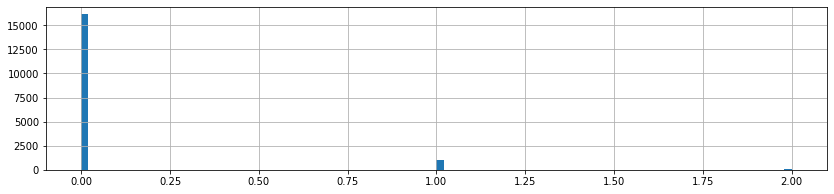

In [ ]:
imputed_train_set.duration_category.hist(bins=100, figsize=(14,3))

In [ ]:
numeric_cols = ['meter_waiting','meter_waiting_fare','meter_waiting_till_pickup',
               'additional_fare','duration','pick_lat','pick_lon','drop_lat','drop_lon',
               'fare','pickup_time_day','pickup_time_hour','pickup_time_minute']

numeric_cols = ['additional','waiting',
                'duration','total_fare','distance',
                'distance_X', 'distance_Y']
categorical_cols = ['pickup_time_hour','duration_category']

used_cols = ['additional_fare', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup',
             'distance','distance_X', 'distance_Y','driving_duration','exact_fare','pickup_time_hour']



In [ ]:
BB = (79.8184, 81.0097, 5.9376, 8.06493)

In [ ]:
td_lables = imputed_train_set.labels
td_train = imputed_train_set.drop('labels', 1)

print(td_train.shape, td_lables.shape, imputed_train_set.shape)

(17175, 46) (17175,) (17175, 47)


In [ ]:
td_train.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,time_of_day,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction,duration_category
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019.0,11.0,1.0,0.0,20.0,2019.0,11.0,1.0,0.0,34.0,0.0,840.0,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0.000000,0.000000,1.000000,1.000000,0.0,280.8200,10.5000,120.0,954.0,-0.249582,778.0,259.820000,-0.142170,-0.139942,-0.172708,152.753420,0.0
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019.0,11.0,1.0,0.0,56.0,2019.0,11.0,1.0,1.0,9.0,0.0,780.0,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0.000000,0.052336,1.000000,0.998630,0.0,208.3500,10.5000,181.0,972.0,-0.092347,744.0,187.350000,0.016182,-0.141058,-0.436406,167.641274,0.0
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019.0,11.0,1.0,1.0,8.0,2019.0,11.0,1.0,1.0,26.0,0.0,1080.0,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0.052336,0.052336,0.998630,0.998630,0.0,312.1400,10.5000,141.0,1228.0,-0.253392,1007.0,291.140000,-0.148956,-0.136965,0.048955,-119.757345,0.0
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019.0,11.0,1.0,2.0,27.0,2019.0,11.0,1.0,2.0,37.0,0.0,600.0,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0.104528,0.104528,0.994522,0.994522,0.0,108.4638,26.1638,339.0,937.0,-0.180218,327.0,56.136200,-0.133121,-0.079627,-1.092480,-103.181677,0.0
4,10.5,1020.0,123.0,0.1166,73.0,6.87441,79.8615,6.84478,79.9290,358.39,2019.0,11.0,1.0,3.0,34.0,2019.0,11.0,1.0,3.0,51.0,0.0,1020.0,8927.76,0.02963,-0.0675,-0.204695,-0.804630,-0.152875,-0.832487,0.156434,0.156434,0.987688,0.987688,0.0,233.7100,10.5385,243.0,1280.0,-0.176971,811.0,187.563285,-0.105975,-0.126672,-0.379805,-66.300305,0.0


In [ ]:
print(tdl.shape, tdd.shape)

(16968, 1) (16968, 45)


In [ ]:
X_train, X_eval, Y_train, Y_eval = train_test_split(
    td_train,
    td_lables,
    test_size=0.20,
    shuffle=True,
    stratify=td_lables,
    random_state=RANDOM_SEED
)



In [ ]:
numeric_preprocessing_steps = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OrdinalEncoder())
    ])


preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("categorical", categorical_transformer, categorical_cols)
    ],
    remainder = "drop"
)

data_pipeline = Pipeline([
    ("preprocessor", preprocessor)
])


In [ ]:
data_pipeline.fit(X_train)
d_train = data_pipeline.transform(X_train)
d_eval = data_pipeline.transform(X_eval)

In [ ]:
print(d_train.shape, d_eval.shape)
Y_train.shape

(13740, 9) (3435, 9)


(13740,)

In [ ]:
d_train[0]

array([1.15314464e-02, 1.36643507e-04, 2.45884302e-03, 6.84054886e-03,
       2.44440055e-01, 5.30865740e-01, 6.62544696e-01, 1.20000000e+01,
       0.00000000e+00])

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
sample_w = compute_sample_weight(class_weight={0:20, 1:1}, y=Y_train)
#sample_w = compute_sample_weight(class_weight='balanced', y=Y_train)

In [ ]:
sample_w

array([ 1.,  1.,  1., ..., 20.,  1.,  1.])

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[400, 800, 1000], 'max_depth':[2,4,8,10,15,20]}

gbclf = GradientBoostingClassifier(random_state=2, subsample = 1.0, verbose = 1)

gridsearch_clf = GridSearchCV(gbclf, parameters)
gridsearch_clf.fit(d_eval, Y_eval)

In [ ]:
sorted(gridsearch_clf.cv_results_)
gridsearch_clf.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

gbclf = GradientBoostingClassifier(random_state=2, n_estimators = 800, max_depth =8, 
                                   subsample = 1.0, verbose = 1)
gbclf.fit(d_train, Y_train, sample_w)
print(gbclf.score(d_eval, Y_eval))
pr = gbclf.predict(d_eval)
print(f1_score(Y_eval, pr, average='macro'))
confusion_matrix(Y_eval, pr)

      Iter       Train Loss   Remaining Time 
         1           1.1547            1.19m
         2           1.0803            1.16m
         3           1.0085            1.16m
         4           0.9499            1.16m
         5           0.9007            1.15m
         6           0.8569            1.16m
         7           0.8199            1.15m
         8           0.7891            1.15m
         9           0.7594            1.16m
        10           0.7286            1.16m
        20           0.5408            1.14m
        30           0.4446            1.13m
        40           0.3791            1.11m
        50           0.3248            1.10m
        60           0.2770            1.09m
        70           0.2401            1.07m
        80           0.2159            1.06m
        90           0.1927            1.04m
       100           0.1714            1.03m
       200           0.0704           52.82s
       300           0.0339           43.92s
       40

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

gbclf = GradientBoostingClassifier(random_state=2, n_estimators = 1000, max_depth =10, 
                                   subsample = 1.0, verbose = 1)
gbclf.fit(d_train, Y_train, sample_w)
print(gbclf.score(d_eval, Y_eval))
pr = gbclf.predict(d_eval)
print(f1_score(Y_eval, pr, average='macro'))
confusion_matrix(Y_eval, pr)

      Iter       Train Loss   Remaining Time 
         1           1.1317            2.04m
         2           1.0453            2.01m
         3           0.9601            2.00m
         4           0.8961            2.01m
         5           0.8369            2.01m
         6           0.7881            2.02m
         7           0.7455            2.03m
         8           0.7083            2.04m
         9           0.6625            2.05m
        10           0.6299            2.06m
        20           0.3830            2.08m
        30           0.2697            2.07m
        40           0.2047            2.06m
        50           0.1620            2.04m
        60           0.1315            2.02m
        70           0.1079            2.00m
        80           0.0890            1.98m
        90           0.0757            1.96m
       100           0.0622            1.94m
       200           0.0140            1.72m
       300           0.0034            1.50m
       40

array([[ 202,  134],
       [  42, 3057]])

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

gbclf = GradientBoostingClassifier(random_state=2, n_estimators = 1000, max_depth =10, 
                                   subsample = 1.0, verbose = 1)
gbclf.fit(d_train, Y_train, sample_w)
print(gbclf.score(d_eval, Y_eval))
pr = gbclf.predict(d_eval)
print(f1_score(Y_eval, pr, average='macro'))
confusion_matrix(Y_eval, pr)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           1.2764            1.72m
         2           1.1844            1.73m
         3           1.1106            1.72m
         4           1.0340            1.75m
         5           0.9690            1.75m
         6           0.9117            1.76m
         7           0.8600            1.76m
         8           0.8121            1.77m
         9           0.7694            1.76m
        10           0.7362            1.76m
        20           0.4583            1.76m
        30           0.3107            1.74m
        40           0.2165            1.72m
        50           0.1627            1.70m
        60           0.1289            1.68m
        70           0.1015            1.67m
        80           0.0826            1.65m
        90           0.0667            1.63m
       100           0.0558            1.61m
       200           0.0103            1.43m
       300           0.0020            1.24m
       40

array([[ 185,  120],
       [  36, 3053]])

In [ ]:
clf = RandomForestClassifier(max_depth=10, random_state=0, class_weight="balanced",
                             n_estimators = 200)
clf.fit(d_train, Y_train)
print(clf.score(d_eval, Y_eval))
pr = clf.predict(d_eval)
print(f1_score(Y_eval, pr, average='macro'))
confusion_matrix(Y_eval, pr)

0.9429403202328966
0.8242093257884809


array([[ 208,  128],
       [  68, 3031]])

In [ ]:
from keras import metrics
import tensorflow as tf

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model = Sequential()
model.add(Dense(64, input_dim=11, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.Precision(), 
                      tf.keras.metrics.Recall()])

In [ ]:
model.fit(d_train, Y_train,batch_size=10, epochs=200)

Epoch 1/200
13740/13740 [==============================] - 2s 121us/step - loss: 0.2011 - precision_2: 0.9412 - recall_2: 0.9921
Epoch 2/200
13740/13740 [==============================] - 2s 114us/step - loss: 0.1928 - precision_2: 0.9413 - recall_2: 0.9921
Epoch 3/200
13740/13740 [==============================] - 2s 114us/step - loss: 0.1910 - precision_2: 0.9413 - recall_2: 0.9921
Epoch 4/200
13740/13740 [==============================] - 2s 113us/step - loss: 0.1924 - precision_2: 0.9413 - recall_2: 0.9921
Epoch 5/200
13740/13740 [==============================] - 2s 113us/step - loss: 0.1930 - precision_2: 0.9414 - recall_2: 0.9921
Epoch 6/200
13740/13740 [==============================] - 2s 113us/step - loss: 0.1904 - precision_2: 0.9414 - recall_2: 0.9921
Epoch 7/200
13740/13740 [==============================] - 2s 113us/step - loss: 0.1893 - precision_2: 0.9414 - recall_2: 0.9921
Epoch 8/200
13740/13740 [==============================] - 2s 115us/step - loss: 0.1892 - precisi

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

pm = model.predict_classes(d_eval)

print(f1_score(Y_eval, pm, average='micro'))
print(f1_score(Y_eval, pm, average='macro'))
confusion_matrix(Y_eval,pm)

0.9414847161572052
0.8061841634325897


array([[ 182,  154],
       [  47, 3052]])

In [ ]:
data_pipeline.fit(td_train)
d_all = data_pipeline.transform(td_train)
y_all = td_lables
print(d_all.shape, y_all.shape)

from sklearn.utils.class_weight import compute_sample_weight
sample_w = compute_sample_weight(class_weight={0:20, 1:1}, y=td_lables)

gbclf = GradientBoostingClassifier(random_state=2, n_estimators = 3000, max_depth =4, 
                                   subsample = 1.0, verbose = 1)
gbclf.fit(d_all, y_all)

(17175, 11) (17175,)
      Iter       Train Loss   Remaining Time 
         1           0.5930            3.40m
         2           0.5625            3.26m
         3           0.5419            3.22m
         4           0.5273            3.22m
         5           0.5173            3.21m
         6           0.5005            3.20m
         7           0.4926            3.19m
         8           0.4837            3.20m
         9           0.4786            3.20m
        10           0.4746            3.20m
        20           0.4038            3.17m
        30           0.3675            3.17m
        40           0.3443            3.15m
        50           0.3302            3.14m
        60           0.3151            3.12m
        70           0.3036            3.12m
        80           0.2971            3.10m
        90           0.2876            3.09m
       100           0.2821            3.08m
       200           0.2314            2.96m
       300           0.1944      

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=3000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [ ]:
cleaned_test_data = preprocess_train_data(test)

test_set = data_pipeline.transform(cleaned_test_data)

In [ ]:
test_set.shape

(8576, 11)

In [ ]:
preds = gbclf.predict(test_set)
print(preds)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
preds.shape

(8576,)

In [ ]:
output = pd.DataFrame(test,columns=['tripid'])
output['prediction'] = preds
output = output.astype({"prediction": int})
output.head()

,tripid,prediction
0,213284604,1
1,213286352,1
2,213293973,1
3,213294622,1
4,213298687,1


In [ ]:
output.to_csv('/content/Ridefare_submission_30.csv',index=False)

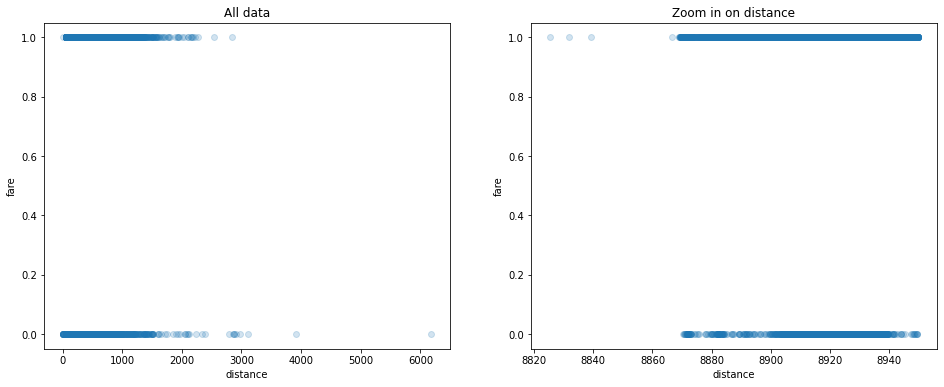

In [ ]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(data_exp.fare, data_exp.labels, alpha=0.2)
axs[0].set_xlabel('distance')
axs[0].set_ylabel('fare')
axs[0].set_title('All data')

# zoom in on part of data
idx = (data_exp.distance < 8950) & (data_exp.fare < 1000)
axs[1].scatter(data_exp[idx].distance, data_exp[idx].labels, alpha=0.2)
axs[1].set_xlabel('distance')
axs[1].set_ylabel('fare')
axs[1].set_title('Zoom in on distance');

